# Notebook 2: Deconvolution with Regularized Linear Regression

### Objective
This notebook implements a Regularized Linear Regression model (specifically, `ElasticNet` from scikit-learn) to deconvolve mitochondrial cluster proportions from single-cell VAF data. It loads the synthetic data generated in the first notebook and, for each cell, it solves for the set of proportions that best explains the observed VAFs.

The model uses cross-validation (`GridSearchCV`) to automatically find the optimal regularization strength (`alpha`) and penalty mix (`l1_ratio`), making it robust to noise. The final section includes a comprehensive suite of validation plots and statistics to compare the model's estimated proportions against the known ground truth.

In [19]:
# 02_implementation_elasticnet.ipynb

### Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from joblib import Parallel, delayed
from tqdm import tqdm

In [20]:
### Cell 2: Load Data from File

input_filename = '../sim_data/simulated_data_regression_02.npz'
print(f"--- Loading data from '{input_filename}' ---")

data_loader = np.load(input_filename)
K_true = data_loader['K_true']
P_cells_true = data_loader['P_cells_true']
C_observed = data_loader['C_observed']

N_CELLS = C_observed.shape[0]
N_CLUSTERS = K_true.shape[1]

print("--- Data Loaded and Ready for Model ---")

--- Loading data from '../sim_data/simulated_data_regression_02.npz' ---
--- Data Loaded and Ready for Model ---


In [21]:
### Cell 3: Implement and Fit the ElasticNet Regression Model (in Parallel)

print("\n--- Fitting ElasticNet Regression Model for each cell ---")

# --- Step 1: Find the best hyperparameters using parallel cross-validation ---
# We use ElasticNet, which combines L1 and L2 penalties.
enet = ElasticNet(positive=True, max_iter=10000)

# Define a grid of parameters to search.
# 'alpha' is the overall strength of regularization.
# 'l1_ratio' controls the mix between L1 (Lasso) and L2 (Ridge).
# l1_ratio=1 is pure Lasso, l1_ratio=0 is pure Ridge.
param_grid = {
    'alpha': np.logspace(-5, -2, 20),
    'l1_ratio': [0.01, 0.1, 0.2, 0.5, 0.9, 0.99, 1]
}

# Use GridSearchCV to find the best combination of alpha and l1_ratio
grid_search = GridSearchCV(enet, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(K_true, C_observed[0, :])
best_params = grid_search.best_params_

print(f"Best alpha found: {best_params['alpha']:.6f}")
print(f"Best l1_ratio found: {best_params['l1_ratio']:.2f}")

# --- Step 2: Fit a model for each cell in parallel using joblib ---
final_enet = ElasticNet(
    alpha=best_params['alpha'],
    l1_ratio=best_params['l1_ratio'],
    positive=True,
    max_iter=10000
)

# Define a function to fit the model for a single cell
def fit_cell(cell_index):
    y = C_observed[cell_index, :]
    X = K_true
    
    final_enet.fit(X, y)
    
    estimated_proportions = final_enet.coef_
    
    # Normalize
    if estimated_proportions.sum() > 0:
        return estimated_proportions / estimated_proportions.sum()
    else:
        return estimated_proportions

# Use joblib.Parallel to run the fit_cell function for all cells across multiple cores
print(f"Fitting models for {N_CELLS} cells in parallel...")
results = Parallel(n_jobs=-1)(delayed(fit_cell)(i) for i in tqdm(range(N_CELLS), desc="Fitting Models"))

# Convert the list of results back into a single numpy array
p_cells_estimated = np.array(results)

print("\n--- Model Fitting Complete ---")


--- Fitting ElasticNet Regression Model for each cell ---
Best alpha found: 0.000010
Best l1_ratio found: 0.01
Fitting models for 1000 cells in parallel...


Fitting Models: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4119.00it/s]



--- Model Fitting Complete ---



--- Initial Validation ---
Mean Squared Error (MSE): 0.000008
Mean Absolute Error (MAE): 0.001543
R-squared (R²): 0.9991


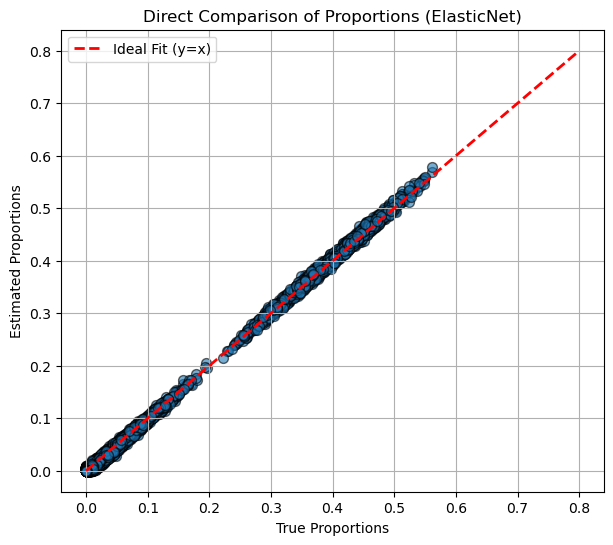

In [23]:
### Cell 4: Initial Validation

print("\n--- Initial Validation ---")

# 1. Calculate Key Performance Metrics
mse = np.mean((P_cells_true - p_cells_estimated)**2)
mae = mean_absolute_error(P_cells_true.flatten(), p_cells_estimated.flatten())
r2 = r2_score(P_cells_true.flatten(), p_cells_estimated.flatten())

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.4f}")

# 2. Compare True vs. Estimated Proportions (Scatter Plot)
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(P_cells_true.flatten(), p_cells_estimated.flatten(), alpha=0.6, edgecolor='k', s=50)
ax.plot([0, 0.8], [0, 0.8], 'r--', lw=2, label='Ideal Fit (y=x)')
ax.set_xlabel('True Proportions')
ax.set_ylabel('Estimated Proportions')
ax.set_title('Direct Comparison of Proportions (ElasticNet)')
ax.grid(True)
ax.legend()
plt.show()


--- Comprehensive Validation and Visualization ---


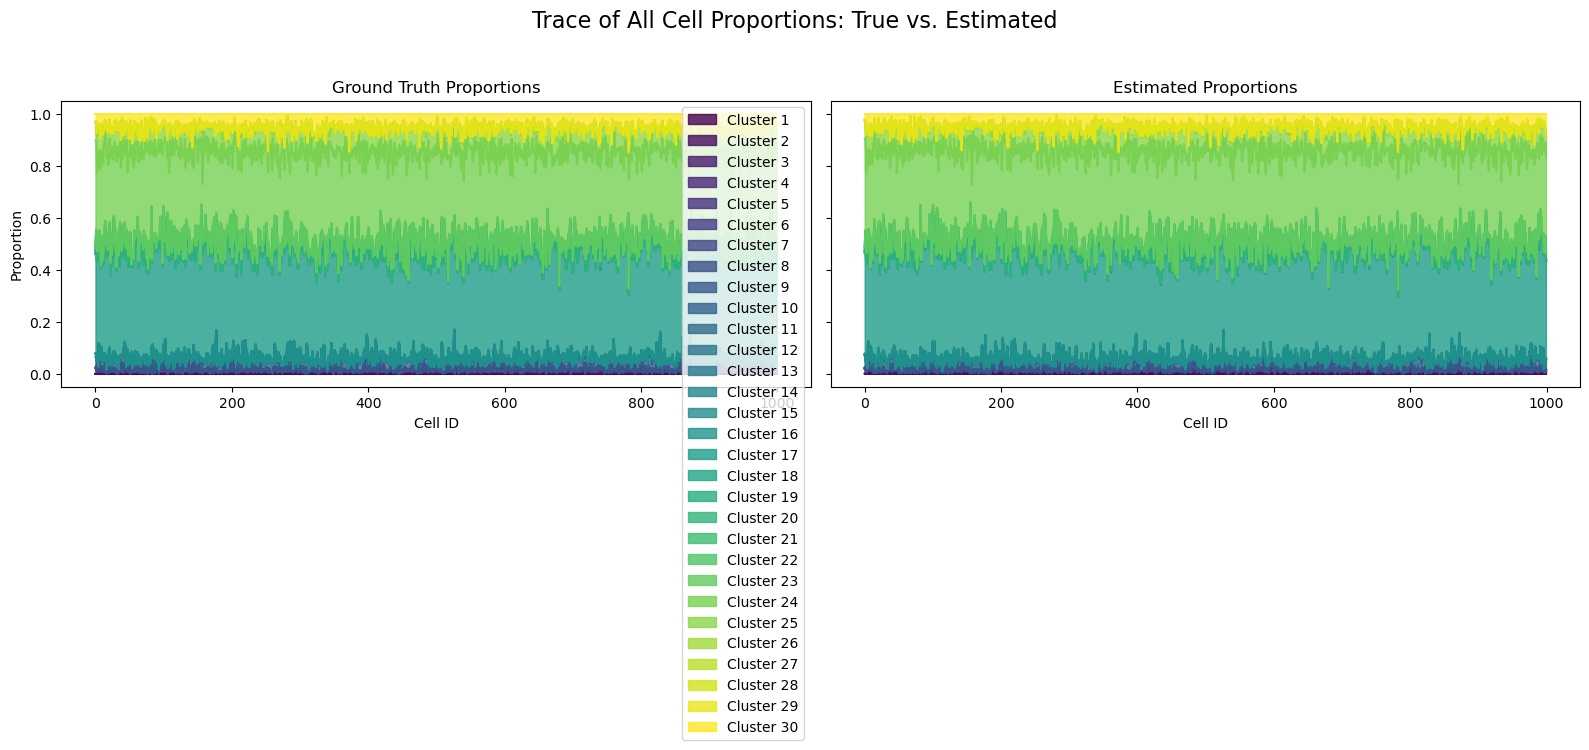

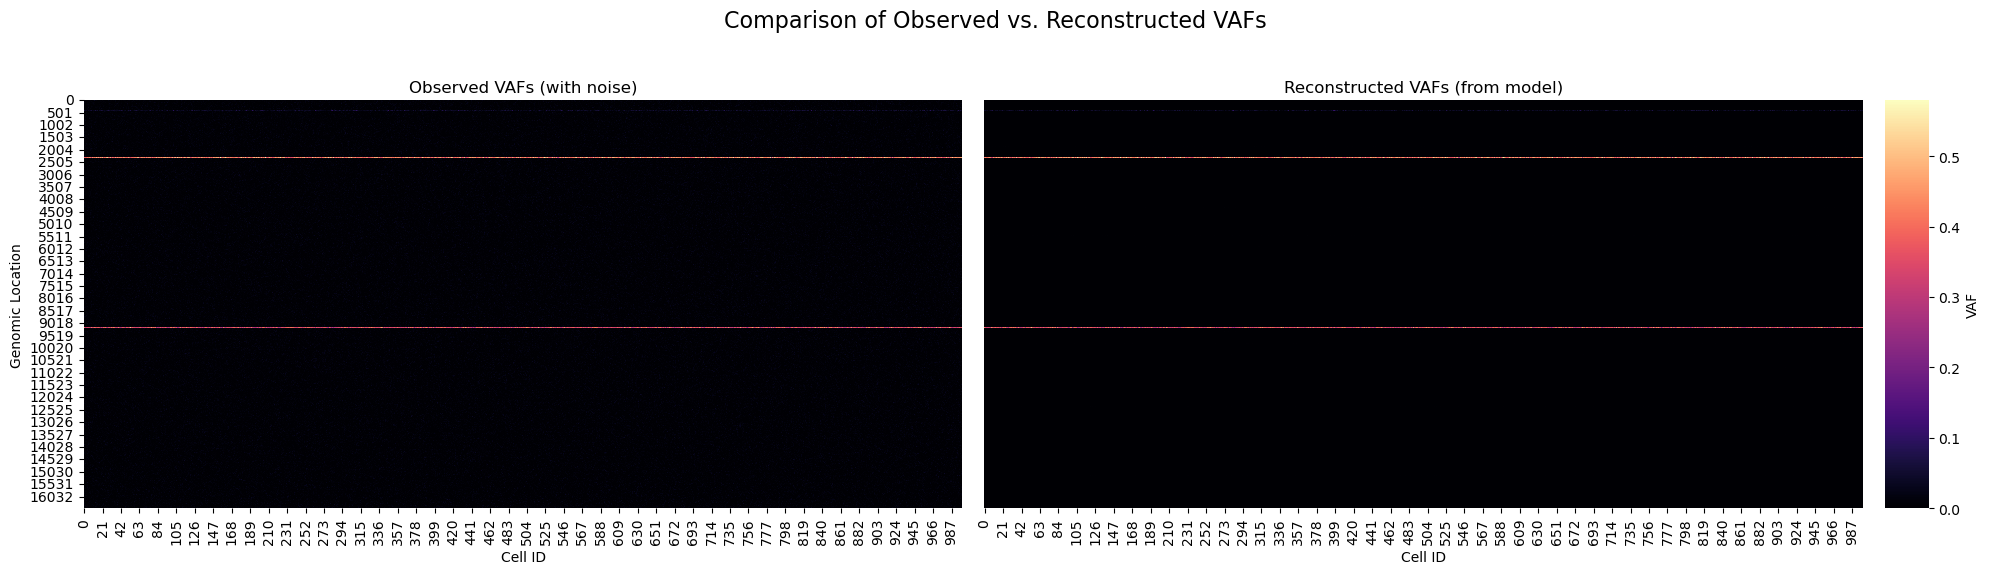

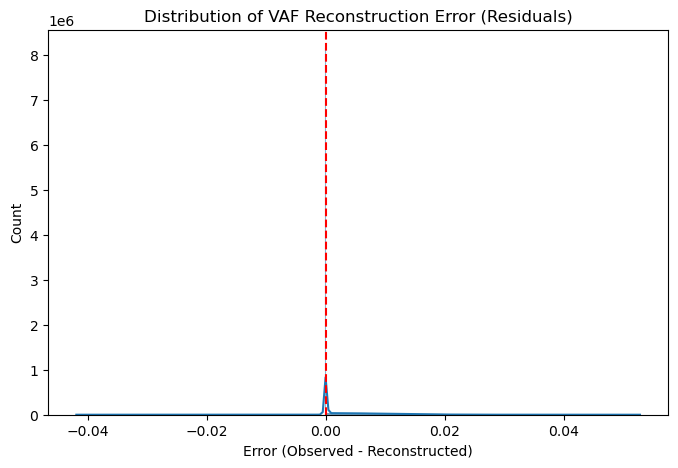

In [24]:
### Cell 5: Comprehensive Validation and Visualization

print("\n--- Comprehensive Validation and Visualization ---")

# --- Question 1: Did the model extract the parameters correctly? ---
# We visualize the full distribution of proportions for all cells.
fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig1.suptitle('Trace of All Cell Proportions: True vs. Estimated', fontsize=16)

# Plot True Cell Proportions
true_df = pd.DataFrame(P_cells_true, columns=[f'Cluster {i+1}' for i in range(N_CLUSTERS)])
true_df.plot(kind='area', stacked=True, ax=axes1[0], colormap='viridis', alpha=0.8)
axes1[0].set_title('Ground Truth Proportions')
axes1[0].set_xlabel('Cell ID')
axes1[0].set_ylabel('Proportion')
axes1[0].legend(loc='upper right')

# Plot Estimated Cell Proportions
est_df = pd.DataFrame(p_cells_estimated, columns=[f'Cluster {i+1}' for i in range(N_CLUSTERS)])
est_df.plot(kind='area', stacked=True, ax=axes1[1], colormap='viridis', alpha=0.8)
axes1[1].set_title('Estimated Proportions')
axes1[1].set_xlabel('Cell ID')
axes1[1].get_legend().remove()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Question 2: Can the model reconstruct the mitochondrial clusters in the cells? ---
# We reconstruct the VAFs using the estimated proportions and compare to the "observed" data.
C_reconstructed = p_cells_estimated @ K_true.T

fig2, axes2 = plt.subplots(1, 3, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 1, 0.05]})
fig2.suptitle('Comparison of Observed vs. Reconstructed VAFs', fontsize=16)

# Plot Observed VAFs
sns.heatmap(C_observed.T, ax=axes2[0], cmap="magma", cbar=False)
axes2[0].set_title('Observed VAFs (with noise)')
axes2[0].set_xlabel('Cell ID')
axes2[0].set_ylabel('Genomic Location')

# Plot Reconstructed VAFs
sns.heatmap(C_reconstructed.T, ax=axes2[1], cmap="magma", cbar_ax=axes2[2], cbar_kws={'label': 'VAF'})
axes2[1].set_title('Reconstructed VAFs (from model)')
axes2[1].set_xlabel('Cell ID')
axes2[1].set_ylabel('')
axes2[1].set_yticks([])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Bonus: Distribution of Reconstruction Error ---
vaf_residuals = C_observed - C_reconstructed
plt.figure(figsize=(8, 5))
sns.histplot(vaf_residuals.flatten(), kde=True)
plt.title('Distribution of VAF Reconstruction Error (Residuals)')
plt.xlabel('Error (Observed - Reconstructed)')
plt.axvline(0, color='r', linestyle='--')
plt.show()